# Import and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import import_ipynb
import os

try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from SpatialTemporal_Correlation_and_Convolution import STconvolve
%matplotlib inline

importing Jupyter notebook from SpatialTemporal_Correlation_and_Convolution.ipynb


In [2]:
def Gaussian_filter_1d(x,s):
    return(np.exp(-(x/s)**2/2))/s/np.sqrt(np.pi*2)

def FB_FF_1l_1D(stimulus, sigma_dict, para_dict, dx, dt, loc_dict = 1):
    if loc_dict == 1:
        loc_dict = {}
        loc_dict['C'] = 1
        loc_dict['H'] = 1
        
    klen = min(max(sigma_dict.values())*3, int(stimulus.shape[1]/2/dx))
    xx = np.arange(-klen,klen+dx,dx)
    KC = Gaussian_filter_1d(xx,sigma_dict['C'])
    KH = Gaussian_filter_1d(xx,sigma_dict['H'])
    KB = Gaussian_filter_1d(xx,sigma_dict['B'])
#     plt.plot(KC)
#     plt.plot(KH)
#     plt.plot(KB)
#     plt.plot(KC-KH)
    
    output = np.zeros_like(stimulus)#y output
    zts = np.zeros_like(stimulus)#horizontal
    yts = np.zeros_like(stimulus)#horizontal
    wts = np.zeros_like(stimulus)#horizontal
    sstm = np.zeros_like(stimulus)
    rpeak1 = np.zeros(np.shape(stimulus)[0])
    rpeak2 = np.zeros(np.shape(stimulus)[0])
    rinvertpeak2 = np.zeros(np.shape(stimulus)[0])
    
    if 'tau_y' in sigma_dict.keys():
        T = np.arange(0,int(sigma_dict['tau_y']/dt*8))*dt
        Ky=T/sigma_dict['tau_y'] /sigma_dict['tau_y'] *np.exp(-T/sigma_dict['tau_y'])
        for j in range(np.shape(stimulus)[1]):
            for i in range(len(Ky)-1):
                for ii in range(i+1):
                    sstm[i,j] += stimulus[ii,j]*Ky[i-ii]*dt
            sx = np.convolve(stimulus[:,j],Ky,'valid')*dt
            sstm[len(Ky)-1:,j] = sx.copy()
    else:
        sstm = stimulus.copy()

    for i in range(np.shape(stimulus)[0]):
        s = sstm[i,:]
        rs = np.convolve(s,KC,'same')*dx
        ry2z = np.convolve(yts[i-1,:],KH,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        dyj =(-para_dict['alpha']*yts[i-1,:]+(rs-zts[i-1,:]))*dt
        dzj =(-para_dict['beta']*zts[i-1,:]+para_dict['g']*ry2z)*dt
                
        yts[i,:] = (yts[i-1,:]+dyj)*loc_dict['C']
        zts[i,:] = (zts[i-1,:]+dzj)*loc_dict['H']
        ry2w = np.convolve(yts[i-1,:],KB,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        dwj =(-para_dict['gramma']*wts[i-2,:]+para_dict['h']*ry2w-para_dict['l']*zts[i-1,:])*dt

        wts[i-1,:] = (wts[i-2,:]+dwj)
        maxpos1 = np.argmax(yts[i,:])
        rpeak1[i]= maxpos1*dx
        maxpos2 = np.argmax(wts[i-1,:])
        rpeak2[i-1]= maxpos2*dx
        maxipos2 = np.argmin(wts[i-1,:])
        rinvertpeak2[i-1]= maxipos2*dx
    
    ry2w = np.convolve(yts[i,:],KB,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
    dwj =(-para_dict['gramma']*wts[i-2,:]+para_dict['h']*ry2w-para_dict['l']*zts[i-1,:])*dt
    wts[i,:] = (wts[i-1,:]+dwj)
    maxpos2 = np.argmax(wts[i,:])
    rpeak2[i]= maxpos2*dx
    maxipos2 = np.argmin(wts[i,:])
    rinvertpeak2[i]= maxipos2*dx
    return wts, zts, yts, rpeak1, rpeak2, rinvertpeak2

In [3]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

# Setting parameters

## CKC's parameters

In [4]:
filename = 'CKC STkernels-good parameters'

NGD_sigma_dict = dict()
NGD_sigma_dict['H'] = 1
NGD_sigma_dict['C'] = NGD_sigma_dict['H']*0.1 # RF size of cone cell
dx = NGD_sigma_dict['H']/40.

dt=0.01 #large dt will cause  overflow
nstep = int(1.6/dt)
NGD_sigma_dict['tau_y'] = 0.027
#Width setting
xlen = 100*NGD_sigma_dict['H'] #spatial extend of simulation

FBFF_para_dict = {}
FBFF_para_dict['alpha'] = 14.
FBFF_para_dict['beta'] = 14.
FBFF_para_dict['gramma'] = 36.
FBFF_para_dict['g'] = 840. # not important if there is no adaption
FBFF_para_dict['h'] = 100
FBFF_para_dict['l'] = 1

FBFF_sigma_dict = NGD_sigma_dict.copy()
FBFF_sigma_dict['B'] = FBFF_sigma_dict['H']*0.3

# TK

In [5]:
TKtaxis = np.arange(0,0.8,dt)
TDelta_input = np.zeros([len(TKtaxis), int(xlen/dx)+1])
TDelta_input[0,:] = 2
TDelta_output_w, zts, TDelta_output_y, _, _, _ = FB_FF_1l_1D(TDelta_input, FBFF_sigma_dict, FBFF_para_dict, dx, dt)
# Delta_output =Delta_output_w

Text(0.5, 1.0, 'temporal filter')

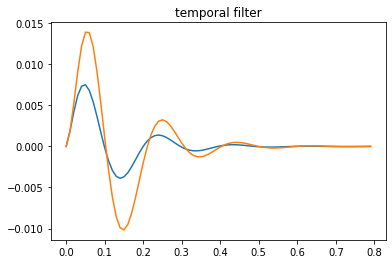

In [6]:
plt.plot(TKtaxis, TDelta_output_y[:len(TKtaxis),int(xlen/dx/2)])
tempTK = TDelta_output_w[:len(TKtaxis),int(xlen/dx/2)]
plt.plot(TKtaxis, tempTK)
plt.title('temporal filter')

In [7]:
delTK = TDelta_output_w[:len(TKtaxis),int(xlen/dx/2)]/dt #normalized by dt

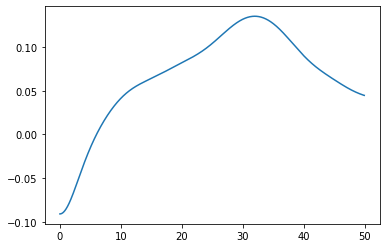

In [8]:
dOmega = 0.05
omega = np.arange(0,50,dOmega)
F_TK = np.sum(delTK[np.newaxis,:]*np.exp(-1j*TKtaxis[np.newaxis,:]*omega[:,np.newaxis]), axis = 1)*dt
Phi = np.angle(F_TK)
delta = -angular_gradient(Phi)/dOmega
plt.plot(omega, delta)

# SK

In [9]:
SDelta_input = np.zeros([nstep, int(xlen/dx)+1])
SDelta_input[:, int(xlen/dx/2)] = 2
SDelta_output_w, zts, SDelta_output_y, _, _, _ = FB_FF_1l_1D(SDelta_input, FBFF_sigma_dict, FBFF_para_dict, dx, dt)

Text(0.5, 1.0, 'spatial filter')

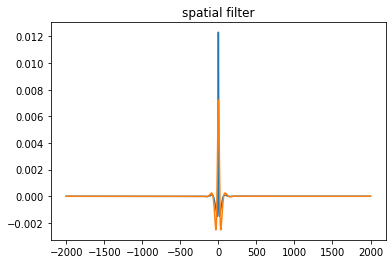

In [10]:
space_window = np.arange(-int(xlen/dx/2),int(xlen/dx/2)+1)
plt.plot(space_window, SDelta_output_y[-1,int(xlen/dx/2)+space_window])
plt.plot(space_window, SDelta_output_w[-1,int(xlen/dx/2)+space_window])
plt.title('spatial filter')

In [11]:
delSK = SDelta_output_w[-1,int(xlen/dx/2)+space_window]/dx

In [12]:
# dwn = 0.001
# wn = np.arange(0,10, dwn)
# F_SK = np.sum(delSK[np.newaxis,:]*np.exp(-1j*(space_window*dx)[np.newaxis,:]*wn[:,np.newaxis]), axis = 1)*dx
# Phi = np.angle(F_SK)
# delta = -angular_gradient(Phi)/dwn
# plt.plot(wn, delta)

# Spatio-Temporal Kernel

In [13]:
Delta_input = np.zeros([nstep, int(xlen/dx)+1])
Delta_input[0, int(xlen/dx/2)] = 2
Delta_output_w, zts, Delta_output_y, _, _, _ = FB_FF_1l_1D(Delta_input, FBFF_sigma_dict, FBFF_para_dict, dx, dt)

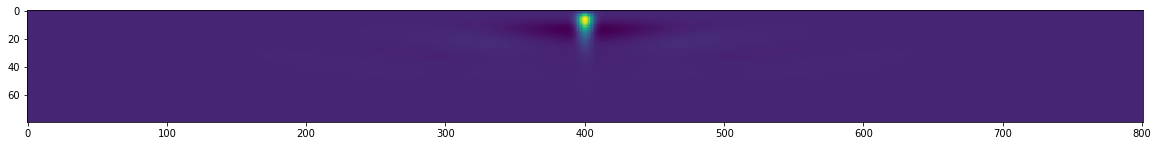

In [14]:
plt.imshow(Delta_output_y[:len(TKtaxis),int(xlen/dx/2)-int(xlen/dx/10):int(xlen/dx/2)+int(xlen/dx/10)+1])
plt.gcf().set_size_inches(20, 5)

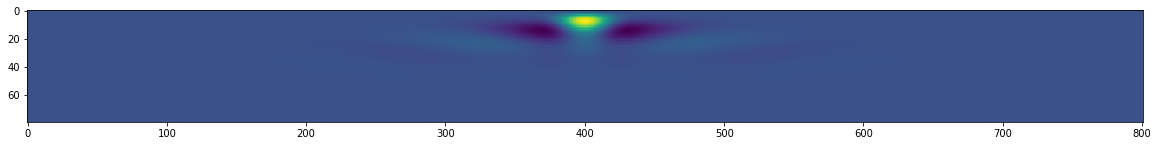

In [15]:
plt.imshow(Delta_output_w[:len(TKtaxis),int(xlen/dx/2)-int(xlen/dx/10):int(xlen/dx/2)+int(xlen/dx/10)+1])
plt.gcf().set_size_inches(20, 5)

In [16]:
delSTK = Delta_output_w[:len(TKtaxis),int(xlen/dx/2)+space_window]/dt/dx

In [17]:
# dOmega = 0.1
# omega = np.arange(0,50,dOmega)
# dwn = 0.002
# wn = np.arange(0,1, dwn)
# F_STKw = np.sum(delSTK[np.newaxis, np.newaxis,:,:]
#                *np.exp(-1j*TKtaxis[np.newaxis, np.newaxis,:,np.newaxis]*omega[:,np.newaxis,np.newaxis,np.newaxis])
#                , axis = 2)*dt
# F_STK = np.squeeze(np.sum(F_STKw[:, np.newaxis,:,:]
#                *np.exp(-1j*(space_window*dx)[np.newaxis, np.newaxis,np.newaxis,:]*wn[np.newaxis,:,np.newaxis,np.newaxis])
#                , axis = 3)*dx)
# F_STK = np.squeeze(F_STK)

# fig, ax = plt.subplots(1,2)
# ax[0].imshow(F_STK.real)
# ax[1].imshow(F_STK.imag)

# Separate by Integration

In [18]:
iTk = np.sum(delSTK, axis = 1)*dx
iSk = np.sum(delSTK, axis = 0)*dt

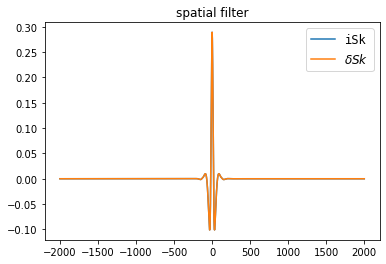

In [19]:
plt.plot(space_window, iSk)
plt.plot(space_window, delSK)
plt.title('spatial filter')

plt.legend( ('iSk', r'$\delta Sk$'), loc='best', prop={'size': 'large', 'family': 'monospace'})

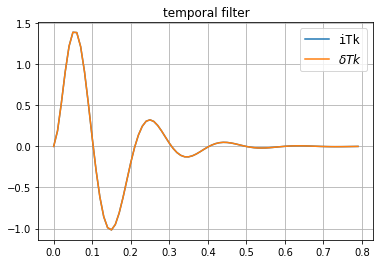

In [20]:
plt.plot(TKtaxis, iTk)
plt.plot(TKtaxis, delTK)
plt.grid()

plt.title('temporal filter')

plt.legend( ('iTk', r'$\delta Tk$'), loc='best', prop={'size': 'large', 'family': 'monospace'})

In [21]:
sSTk = iSk[np.newaxis,:]*iTk[:, np.newaxis]
# ssSTk = cut_Delta_output[np.newaxis,:]*np.flipud(n_TK[:len(iTk), np.newaxis])

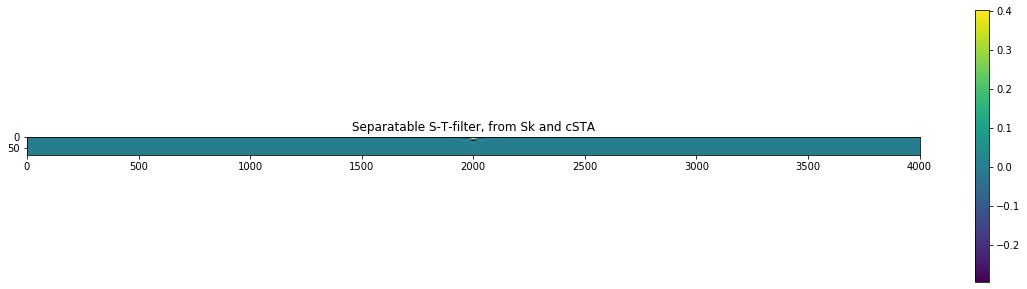

In [22]:
plt.imshow(sSTk)
plt.colorbar()
plt.title('Separatable S-T-filter, '+'from Sk and cSTA')
fig = plt.gcf()
fig.set_size_inches(20, 5)

# Apply SVD on Spatial-Temporal Kernel

In [23]:
from numpy import linalg as la
U,sigma,VT=la.svd(delSTK)

#U and VT are unitary martrices, So U1 and V1 are normalized vector 

In [24]:
sigma

array([3.14656159e+01, 1.48796946e+01, 5.23421289e+00, 1.72254513e+00,
       5.70334910e-01, 1.89120901e-01, 6.25028237e-02, 2.07085450e-02,
       6.72217259e-03, 1.67664602e-03, 4.26507750e-04, 1.60004869e-04,
       1.00795950e-05, 5.11225392e-07, 6.37657162e-08, 1.45379790e-08,
       4.07419925e-10, 3.31882149e-11, 6.81111162e-12, 1.77106010e-13,
       1.44085269e-14, 3.72811937e-15, 2.95753890e-15, 2.57653673e-15,
       2.57653673e-15, 2.57653673e-15, 2.57653673e-15, 2.57653673e-15,
       2.57653673e-15, 2.57653673e-15, 2.57653673e-15, 2.57653673e-15,
       2.57653673e-15, 2.57653673e-15, 2.57653673e-15, 2.57653673e-15,
       2.57653673e-15, 2.57653673e-15, 2.57653673e-15, 2.57653673e-15,
       2.57653673e-15, 2.57653673e-15, 2.57653673e-15, 2.57653673e-15,
       2.57653673e-15, 2.57653673e-15, 2.57653673e-15, 2.57653673e-15,
       2.57653673e-15, 2.57653673e-15, 2.57653673e-15, 2.57653673e-15,
       2.57653673e-15, 2.57653673e-15, 2.57653673e-15, 2.57653673e-15,
      

In [25]:
(sigma/sum(sigma))[:5]

array([0.58104243, 0.27476767, 0.0966547 , 0.03180843, 0.01053177])

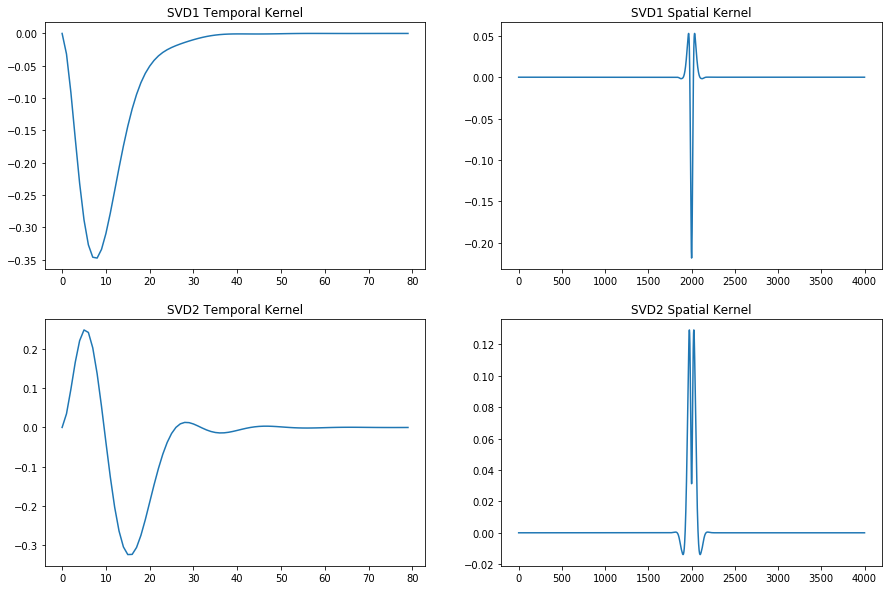

In [26]:
fig, ((ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=2, ncols=2)
ax2.plot(U[:,0])
ax2.set_title('SVD1 Temporal Kernel')
ax3.plot(VT[0,:])
ax3.set_title('SVD1 Spatial Kernel')
ax4.plot(U[:,1])
ax4.set_title('SVD2 Temporal Kernel')
ax5.plot(VT[1,:])
ax5.set_title('SVD2 Spatial Kernel')
fig.set_size_inches(15, 10)

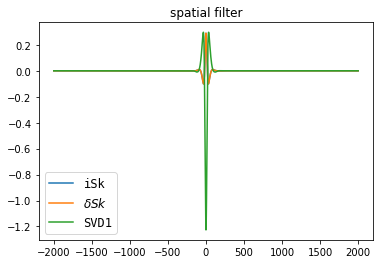

In [27]:
plt.plot(space_window, iSk, label = 'iSk')
plt.plot(space_window, delSK, label = r'$\delta Sk$')
plt.plot(space_window, VT[0,:]*np.sqrt(sigma[0]), label = 'SVD1')
# plt.plot(space_window, VT[1,:]/max(VT[1,:]), label = 'SVD2')

plt.title('spatial filter')
plt.legend(loc='best', prop={'size': 'large', 'family': 'monospace'})

# plt.xlim([-30, 30])

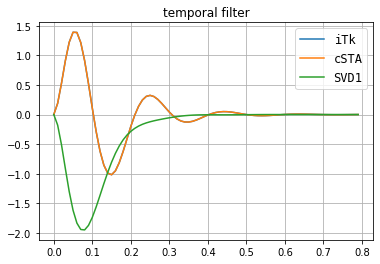

In [28]:
plt.plot(TKtaxis, iTk)
plt.plot(TKtaxis, delTK)
plt.plot(TKtaxis, U[:,0]*np.sqrt(sigma[0]))
# plt.plot(TKtaxis, U[:,1]/max(U[:,1]))
plt.grid()

plt.title('temporal filter')

plt.legend( ('iTk', 'cSTA', 'SVD1', 'SVD2'), loc='best', prop={'size': 'large', 'family': 'monospace'})

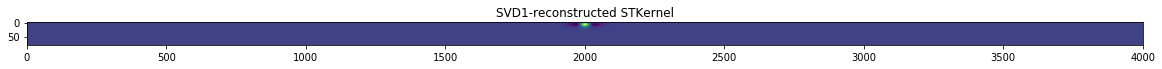

In [29]:
cSVD = 0
SVD_STkernel = U[:,cSVD][:, np.newaxis]*VT[cSVD,:][np.newaxis, :]*sigma[0]
plt.imshow(SVD_STkernel)
plt.title('SVD'+str(cSVD+1)+'-reconstructed STKernel')
fig = plt.gcf()
fig.set_size_inches(20, 5)

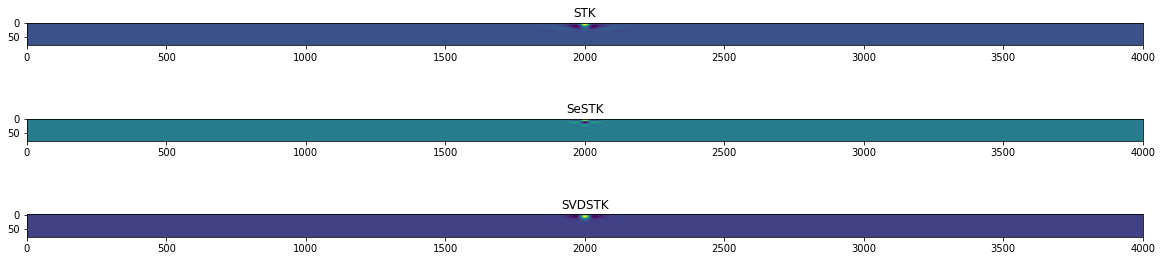

In [30]:
fig, ax = plt.subplots(3,1)
ax[0].imshow(delSTK)
ax[0].set_title('STK')
ax[1].imshow(sSTk)
ax[1].set_title('SeSTK')
ax[2].imshow(SVD_STkernel)
ax[2].set_title('SVDSTK')
plt.gcf().set_size_inches(20, 5)

Rs2d = np.max(delSTK)/np.max(sSTk)

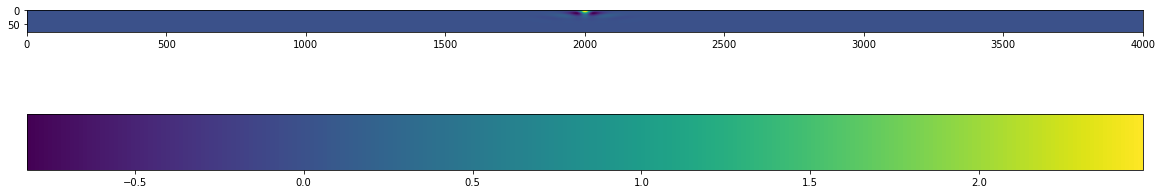

In [31]:
plt.imshow(delSTK)
plt.colorbar(orientation="horizontal")
plt.gcf().set_size_inches(20, 10)

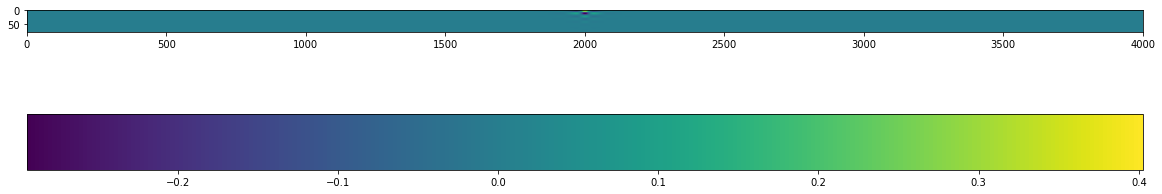

In [32]:
plt.imshow(sSTk)
plt.colorbar(orientation="horizontal")
plt.gcf().set_size_inches(20, 10)

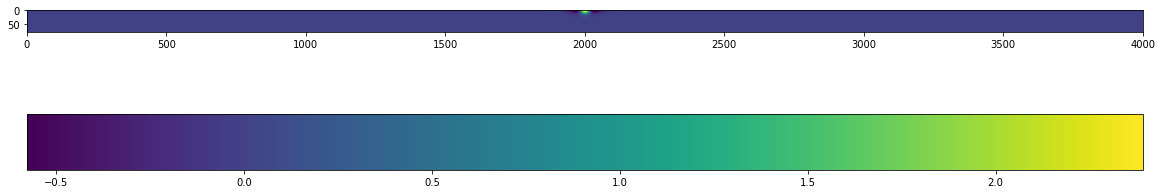

In [33]:
plt.imshow(SVD_STkernel)
plt.colorbar(orientation="horizontal")
plt.gcf().set_size_inches(20, 10)

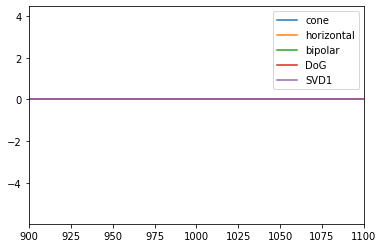

In [34]:
KC = Gaussian_filter_1d(space_window*dx,FBFF_sigma_dict['C'])
KH = Gaussian_filter_1d(space_window*dx,FBFF_sigma_dict['H'])
KB = Gaussian_filter_1d(space_window*dx,FBFF_sigma_dict['B'])
plt.plot(KC, label = 'cone')
plt.plot(KH, label = 'horizontal')
plt.plot(KB, label = 'bipolar')
plt.plot(KC-KH, label = 'DoG')
plt.plot(VT[0,:]/max(VT[0,:])*max(KB), label = 'SVD1')

plt.xlim([1000-100, 1000+100])
plt.legend()

[0.22366077 0.85087934 0.26092227 0.32235352]


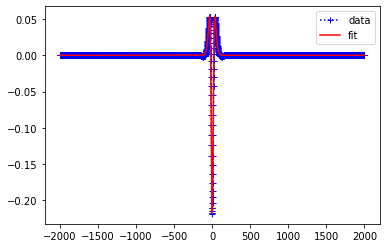

In [35]:
from scipy.optimize import curve_fit
SK = VT[0,:]

def DoG(x, a1, sigma1, a2, sigma2):
    return a1*Gaussian_filter_1d(x,sigma1)-a2*Gaussian_filter_1d(x,sigma2)

popt,pcov = curve_fit(DoG, space_window, SK, p0=[max(SK), 23, 0.1*max(SK), 5*23], bounds = (0, np.inf))
# popt,pcov = curve_fit(DoG, space_window, SK, p0=[max(SK)/2, 23, -0.1*max(SK), 5*23])
print(popt*dx)

plt.plot(space_window, SK, 'b+:', label='data')
plt.plot(space_window,  DoG(space_window, *popt), 'r-', label='fit')
plt.legend()

In [36]:
print(popt*dx)
print(popt)
FBFF_sigma_dict

[0.22366077 0.85087934 0.26092227 0.32235352]
[ 8.94643079 34.03517347 10.43689081 12.89414061]


{'H': 1, 'C': 0.1, 'tau_y': 0.027, 'B': 0.3}

# Steady State of Constant Moving Bar
SK of moving frame

In [37]:
def SquareWave(hw):
    xaxis = np.arange(-hw-1, hw+2)
    SW = np.ones_like(xaxis)
    SW[[0,-1]] = 0
    return SW
def GaussianWave(sigma):
    xaxis = np.arange(-5*sigma, 5*sigma+1)
    return (np.exp(-(xaxis/sigma)**2/2))

In [38]:
def StadyState_ConstMoveDelta(v, Kernel): #note that v here is dimensionless
    last_mb_y = np.zeros_like(Kernel[0,:])
    for k in range(Kernel.shape[0]):
        shift = int(v*k)
        last_mb_y += np.append(Kernel[k,shift:], np.zeros(shift))*dt
    return last_mb_y

In [39]:
delSTKv1 = StadyState_ConstMoveDelta(1, delSTK)
sSTkv1 = StadyState_ConstMoveDelta(1, sSTk)

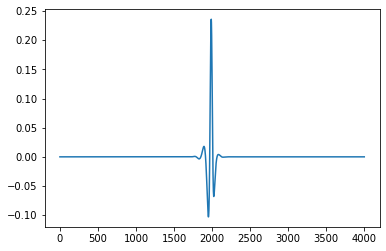

In [40]:
plt.plot(delSTKv1)

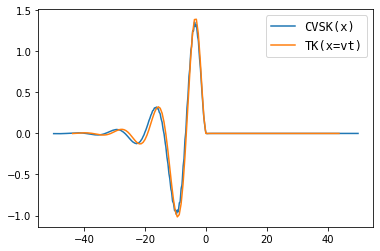

In [61]:
v = 25 #note that v here is dimensionless
delSKvp = StadyState_ConstMoveDelta(v, delSTK)

plt.plot(space_window*dx,delSKvp*(v*dx/dt), label='CVSK(x)')

new_TK = np.flip(np.append(np.zeros(70),delTK[:71]))
newTaxis = np.arange(-70,71)*dt
plt.plot(newTaxis*(v*dx/dt), new_TK, label='TK(x=vt)')

plt.legend(loc='best', prop={'size': 'large', 'family': 'monospace'})

In [42]:
new_TK = np.hstack((np.zeros(1930), np.flip(np.append(np.zeros(70),delTK[:71])), np.zeros(1930)))
newTaxis = np.arange(-2000,2001)*dt

v_list = np.arange(1.0,51.0) #note that v here is dimensionless
height = np.zeros_like(v_list)
error = np.zeros_like(v_list)
for i in range(len(v_list)):
    v = v_list[i]
    delSKvp = StadyState_ConstMoveDelta(v, delSTK)
    height[i] = max(delSKvp)
    f = interpolate.interp1d(newTaxis, new_TK)
#     print(max(newTaxis), max(space_window/v*dt))
    Tkvt = f(space_window/v*dt)
    error[i] = sum((Tkvt-delSKvp*(v*dx/dt))**2)

1.3912051028396717


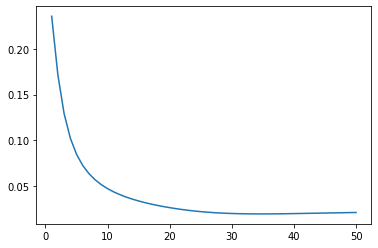

In [43]:
plt.plot(v_list, height)
print(max(Tkvt))

28.0


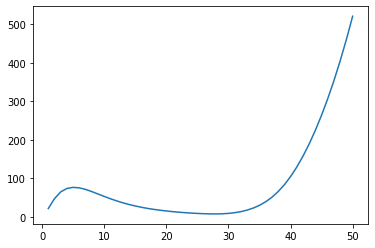

In [44]:
# theoretically, error should be monotonic decreasing. Yet, we need smaller dt for larger v in dircrete numerical stimulation.
plt.plot(v_list,error)
print(v_list[np.argmin(error)])

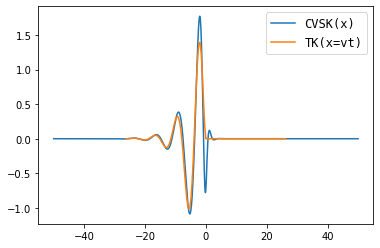

In [91]:
v = 15 #note that v here is dimensionless
SeSKvp = StadyState_ConstMoveDelta(v, sSTk)

plt.plot(space_window*dx,SeSKvp*(v*dx/dt)*20, label='CVSK(x)')

new_TK = np.flip(np.append(np.zeros(70),delTK[:71]))
newTaxis = np.arange(-70,71)*dt
plt.plot(newTaxis*(v*dx/dt), new_TK, label='TK(x=vt)')

plt.legend(loc='best', prop={'size': 'large', 'family': 'monospace'})

In [56]:
new_TK = np.hstack((np.zeros(1930), np.flip(np.append(np.zeros(70),delTK[:71])), np.zeros(1930)))
newTaxis = np.arange(-2000,2001)*dt

v_list = np.arange(1.0,51.0) #note that v here is dimensionless
height = np.zeros_like(v_list)
error = np.zeros_like(v_list)
for i in range(len(v_list)):
    v = v_list[i]
    SeSKvp = StadyState_ConstMoveDelta(v, sSTk)
    height[i] = max(SeSKvp)
    f = interpolate.interp1d(newTaxis, new_TK)
#     print(max(newTaxis), max(space_window/v*dt))
    Tkvt = f(space_window/v*dt)
    error[i] = sum((Tkvt-SeSKvp*(v*dx/dt)*25)**2)

1.3912051028396717


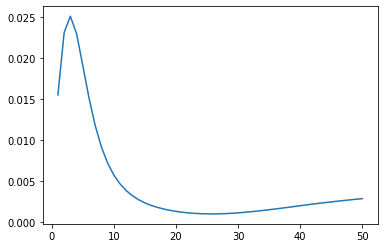

In [57]:
plt.plot(v_list, height)
print(max(Tkvt))

24.0


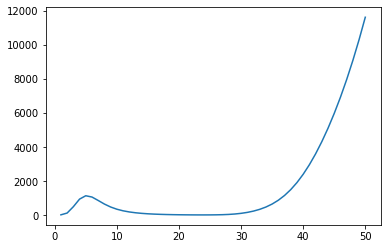

In [58]:
# theoretically, error should be monotonic decreasing. Yet, we need smaller dt for larger v in dircrete numerical stimulation.
plt.plot(v_list,error)
print(v_list[np.argmin(error)])

## Fourier Transform

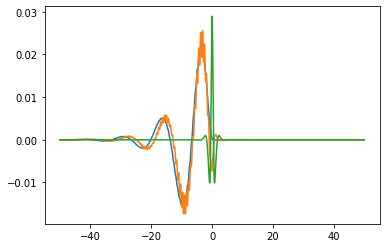

In [85]:
v = 25
delSKvp = StadyState_ConstMoveDelta(v, delSTK)
SeSKvp = StadyState_ConstMoveDelta(v, sSTk)
plt.plot(space_window*dx,delSKvp)
plt.plot(space_window*dx,SeSKvp*25)
plt.plot(space_window*dx,delSK/10)

Text(0.5, 0, 'wavenumber k ($L^{-1}$)')

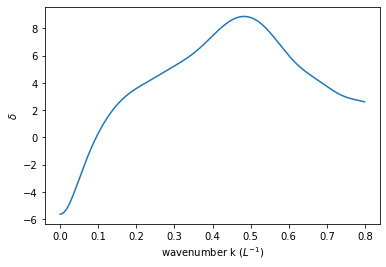

In [69]:
dwn = 0.001
wn = np.arange(0, 50/(v*dx/dt), dwn) # k = omega / vp

F_SK = np.sum(delSKvp[np.newaxis,::-1]*np.exp(-1j*(space_window*dx)[np.newaxis,:]*wn[:,np.newaxis]), axis = 1)*dx #need to flip delSKvp
Phi = np.angle(F_SK)
delta = -angular_gradient(Phi)/dwn
plt.plot(wn, delta)

plt.ylabel(r'$\delta$')
plt.xlabel(r'wavenumber k ($L^{-1}$)')

Text(0.5, 0, 'Angular Frequency $\\omega$ ($s^{-1}$)')

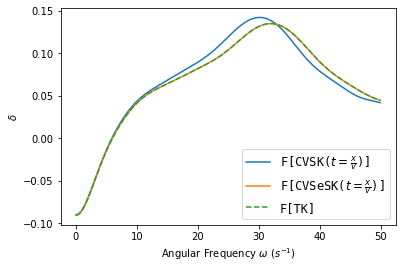

In [73]:
dOmega = 0.05
omega = np.arange(0,50,dOmega)

F_SK = np.sum(delSKvp[np.newaxis,::-1]*np.exp(-1j*(space_window/v*dt)[np.newaxis,:]*omega[:,np.newaxis]), axis = 1)*dx #need to flip delSKvp
Phi = np.angle(F_SK)
delta = -angular_gradient(Phi)/dOmega
plt.plot(omega, delta, label=r'F[CVSK($t=\frac{x}{v}$)]')

F_SK2 = np.sum(SeSKvp[np.newaxis,::-1]*np.exp(-1j*(space_window/v*dt)[np.newaxis,:]*omega[:,np.newaxis]), axis = 1)*dx #need to flip delSKvp
Phi = np.angle(F_SK2)
delta = -angular_gradient(Phi)/dOmega
plt.plot(omega, delta, label=r'F[CVSeSK($t=\frac{x}{v}$)]')

F_TK = np.sum(delTK[np.newaxis,:]*np.exp(-1j*TKtaxis[np.newaxis,:]*omega[:,np.newaxis]), axis = 1)*dt
Phi = np.angle(F_TK)
delta = -angular_gradient(Phi)/dOmega
plt.plot(omega, delta,  '--', label='F[TK]')

plt.legend(loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.ylabel(r'$\delta$')
plt.xlabel(r'Angular Frequency $\omega$ ($s^{-1}$)')